## Analyzing the training images

In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pyod
import sklearn
from cycler import cycler
from fast.utils.img_loader import load_image_list_renormalize, renormalize
from markers_and_labels import KWARGS_PER_LABEL, LABELS
from scipy import stats
from sklearn import feature_extraction
from tqdm.notebook import tqdm

In [116]:
# plt.rcParams['font.family'] = 'monospace'

In [117]:
def get_feature_vectors(img, psize=[21, 21], c=2, n_points_min=5, n_points_max=25):
    cy = psize[0] // 2
    cx = psize[1] // 2
    patches = sklearn.feature_extraction.image.extract_patches_2d(img, psize)
    rvals = np.linspace(-cx, cx, psize[0])
    radii = (rvals[:, None] ** 2 + rvals[None, :] ** 2) ** 0.5
    scalings = np.zeros_like(radii)
    scalings[radii > 0] = (1 / radii[radii > 0] * 2) / np.sum(1 / radii[radii > 0] ** 2)

    test = "a"
    stds_this = []
    weights_this = []
    rds_this = []
    gx_this = []
    gy_this = []
    for p in patches:
        n_points = np.random.randint(n_points_min, n_points_max)
        points_to_take = np.random.randint(0, p.size, n_points)
        # points_to_take = np.arange(p.size)
        points = p.ravel()[points_to_take]
        diffs = np.abs(points - p[cx, cy])

        scs = scalings.ravel()[points_to_take]
        weighted = diffs * scs  # [points_to_take]

        radii_this = radii.ravel()[points_to_take]
        # try:
        sigma = np.min(radii_this[radii_this > 0]) / c
        # except:
        #    print(n_points, points_to_take)
        #    raise

        h = np.exp(-(radii_this**2) / (2 * sigma**2))

        rds = h * diffs

        gx = abs(p[cy, cx - 1] - p[cy, cx + 1])
        gy = abs(p[cy - 1, cx] - p[cy + 1, cx])
        gx_this.append(gx)
        gy_this.append(gy)

        stds_this.append((np.mean(diffs**2)) ** 0.5)
        weights_this.append(np.sum(weighted))
        rds_this.append(np.sum(rds))

    feature_vector = np.array([gx_this, gy_this, stds_this, weights_this]).T
    rds = np.array(rds_this)
    return feature_vector, patches, rds_this, scalings

In [19]:
base_path = Path("selected_images/")
image_files_all = list(base_path.glob("*.tiff"))

In [20]:
figures_path = Path("paper_figures_and_results")

In [21]:
images_all = load_image_list_renormalize(
    image_files_all, img_format="tiff"
)  # , min_normalized_value=0,max_normalized_value=1)

In [49]:
titles_all = []
for imf in image_files_all:
    titl = imf.stem
    if titl in LABELS:
        titl = LABELS[titl]
    if titl == "cameraman_unscaled":
        titl = "cameraman"
    titles_all.append(titl)

In [52]:
feature_vectors_all = []
patches_all = []
scalings = None
rds_all = []
for img in tqdm(images_all):
    feat, patches, rds, scalings = get_feature_vectors(img)
    feature_vectors_all.append(feat)
    rds_all.append(rds)
    patches_all.append(patches)

  0%|          | 0/11 [00:00<?, ?it/s]

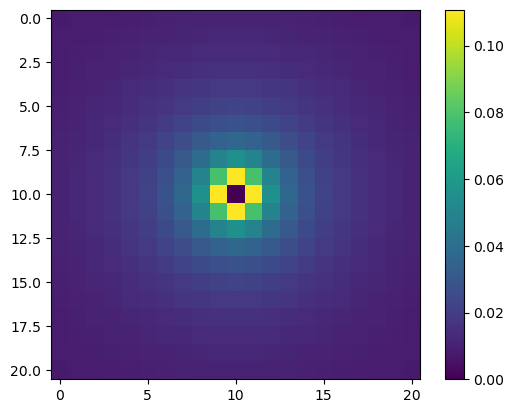

In [53]:
plt.imshow(scalings)
plt.colorbar()

In [54]:
patches_all[0].shape

(55696, 21, 21)

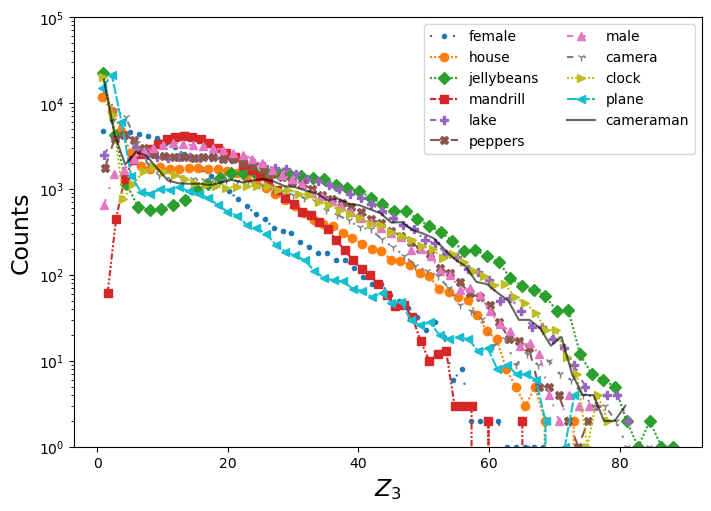

In [56]:
plt.figure(figsize=[7, 5], constrained_layout=True)
for _ix, feats in enumerate(feature_vectors_all):
    stds = feats[:, 2]
    counts, edges = np.histogram(stds, bins=50)  # , density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])
    # plt.hist(gradients_all[_ix][0].ravel(), bins=100)
    label = f"{titles_all[_ix]}"
    plt.plot(centers, counts, label=label, **KWARGS_PER_LABEL[titles_all[_ix]])  # , markevery=0.1)
plt.legend(loc="best", ncols=2)
plt.ylim(1e0, 1e5)
plt.yscale("log")
# plt.xscale('log')
plt.xlabel(r"$Z_3$", fontsize=17)
plt.ylabel("Counts", fontsize=17)
plt.savefig(
    f"{figures_path}/training_z3_counts.svg",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.savefig(
    f"{figures_path}/training_z3_counts.pdf",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.show()

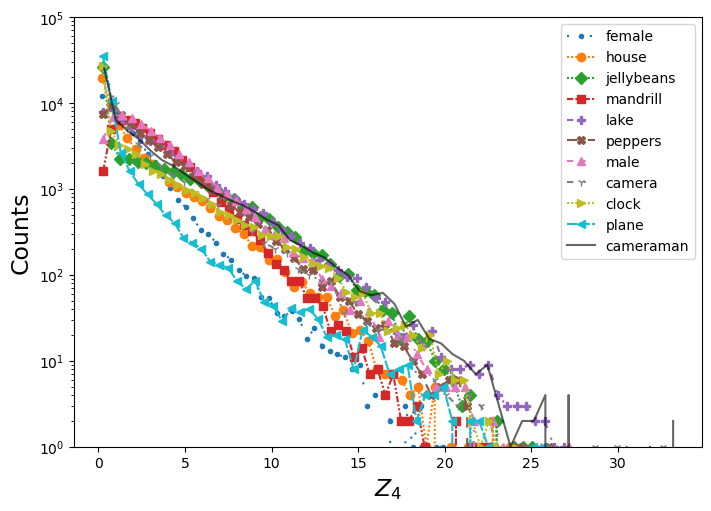

In [58]:
pc = prop_cycler()
plt.figure(figsize=[7, 5], constrained_layout=True)
for _ix, feats in enumerate(feature_vectors_all):
    weights = feats[:, 3]
    counts, edges = np.histogram(weights, bins=50)
    centers = 0.5 * (edges[1:] + edges[:-1])
    auc = np.sum(counts * (edges[1] - edges[0]))
    label = f"{titles_all[_ix]}"
    plt.plot(centers, counts, label=label, **KWARGS_PER_LABEL[titles_all[_ix]])  # , markevery=0.1)
plt.legend(loc="best")
plt.yscale("log")
plt.ylim(1e0, 1e5)
plt.xlabel(r"$Z_4$", fontsize=17)
plt.ylabel("Counts", fontsize=17)

plt.savefig(
    f"{figures_path}/training_z4_counts.svg",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.savefig(
    f"{figures_path}/training_z4_counts.pdf",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.show()

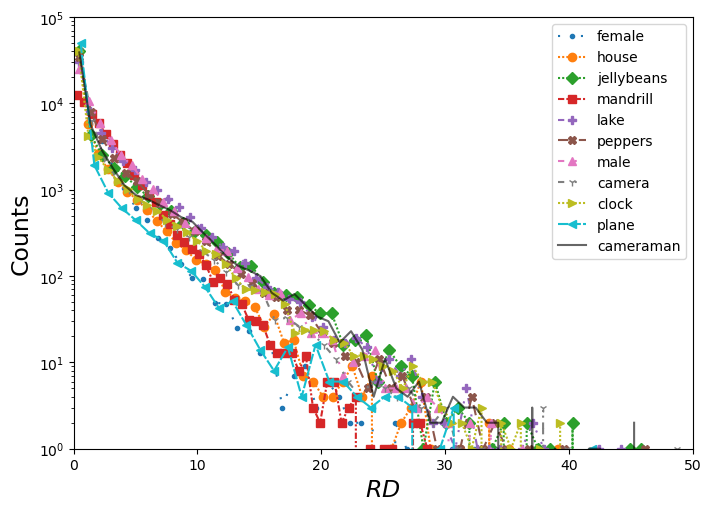

In [62]:
pc = prop_cycler()
plt.figure(figsize=[7, 5], constrained_layout=True)
for _ix, rds in enumerate(rds_all):
    counts, edges = np.histogram(rds, bins=50)
    centers = 0.5 * (edges[1:] + edges[:-1])
    auc = np.sum(counts * (edges[1] - edges[0]))
    label = f"{titles[_ix]: <10} {auc: <5.2g}"
    # plt.plot(centers, counts, label=label, **next(pc), markevery=0.15)
    density = stats.gaussian_kde(weights)
    x = np.linspace(weights.min(), weights.max(), 50)
    label = f"{titles_all[_ix]}"
    plt.plot(centers, counts, label=label, **KWARGS_PER_LABEL[titles_all[_ix]])  # , markevery=0.05)
#
#    plt.title(title)
plt.legend(loc="best")
plt.yscale("log")
plt.ylim(1e0, 1e5)
plt.xlim([0, 50])
plt.xlabel(r"$RD$", fontsize=17)
plt.ylabel("Counts", fontsize=17)

plt.savefig(
    f"{figures_path}/training_rd_counts.svg",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.savefig(
    f"{figures_path}/training_rd_counts.pdf",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.show()

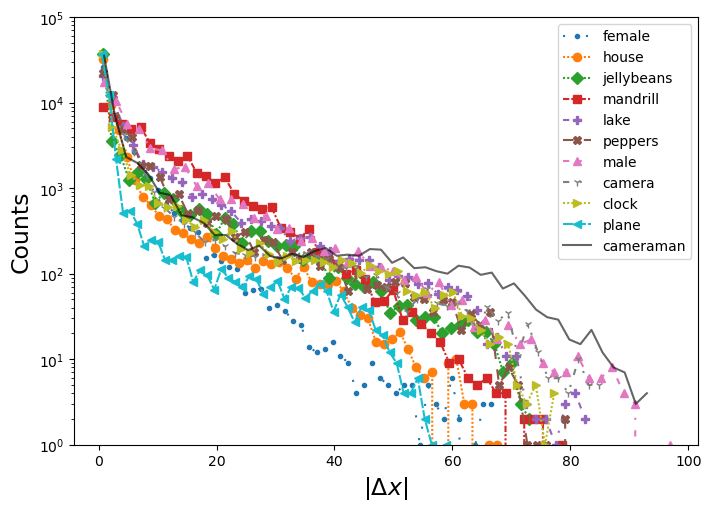

In [63]:
pc = prop_cycler()
plt.figure(figsize=[7, 5], constrained_layout=True)
for _ix, feats in enumerate(feature_vectors_all):
    gx = feats[:, 0]
    counts, edges = np.histogram(gx, bins=50)
    centers = 0.5 * (edges[1:] + edges[:-1])
    auc = np.sum(counts * (edges[1] - edges[0]))
    label = f"{titles_all[_ix]}"
    plt.plot(centers, counts, label=label, **KWARGS_PER_LABEL[titles_all[_ix]])  # , markevery=0.05)

plt.legend(loc="best")
plt.yscale("log")
plt.ylim(1e0, 1e5)
plt.xlabel(r"$|\Delta x|$", fontsize=17)
plt.ylabel("Counts", fontsize=17)

plt.savefig(
    f"{figures_path}/training_dx_counts.svg",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.savefig(
    f"{figures_path}/training_dx_counts.pdf",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.show()

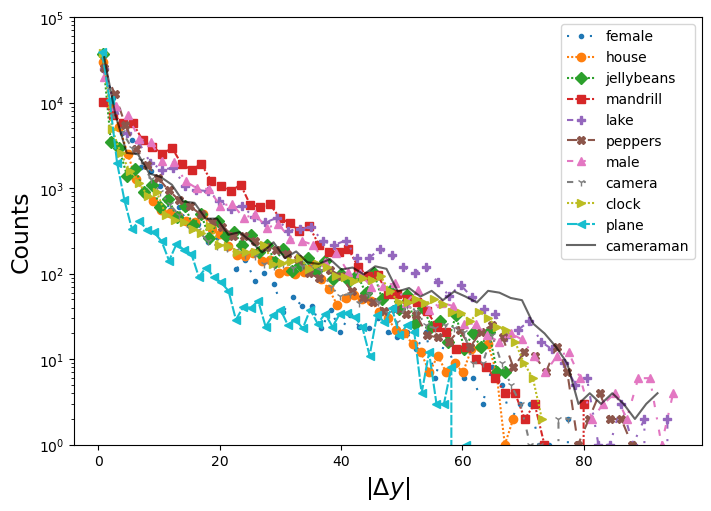

In [64]:
pc = prop_cycler()
plt.figure(figsize=[7, 5], constrained_layout=True)
for _ix, feats in enumerate(feature_vectors_all):
    gy = feats[:, 1]
    counts, edges = np.histogram(gy, bins=50)
    centers = 0.5 * (edges[1:] + edges[:-1])
    auc = np.sum(counts * (edges[1] - edges[0]))
    label = f"{titles_all[_ix]}"
    plt.plot(centers, counts, label=label, **KWARGS_PER_LABEL[titles_all[_ix]])  # , markevery=0.05)

plt.legend(loc="best")
plt.yscale("log")
plt.ylim(1e0, 1e5)
plt.xlabel(r"$|\Delta y|$", fontsize=17)
plt.ylabel("Counts", fontsize=17)

plt.savefig(
    f"{figures_path}/training_dy_counts.svg",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.savefig(
    f"{figures_path}/training_dy_counts.pdf",
    bbox_inches="tight",
    dpi=600,
    transparent=True,
)
plt.show()

### Novelty detection

In [65]:
from copy import deepcopy

from sklearn.ensemble import IsolationForest

# from pyod.models.ecod import  ECOD
# from pyod.models.iforest import IForest
# from sklearn.neighbors import LocalOutlierFactor

In [66]:
from sklearn.pipeline import make_pipeline

In [67]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
nu = 0.05
gamma = 0.5
random_state = 42

In [70]:
n_repeats = 5

In [72]:
fitted_sgds = {}
fitted_isofs = {}
for _if, feats in tqdm(enumerate(feature_vectors_all)):
    print(titles[_if])
    for _ir in range(n_repeats):
        scaler = StandardScaler()
        transform = Nystroem(gamma=gamma)
        clf_sgd = SGDOneClassSVM(
            nu=nu,
            shuffle=True,
            fit_intercept=True,
            tol=1e-4,
            max_iter=10000,
        )
        pipe_sgd = make_pipeline(scaler, transform, clf_sgd)

        predicted = pipe_sgd.fit_predict(feats)
        fitted_sgds.setdefault(titles[_if], [])
        fitted_sgds[titles[_if]].append(deepcopy(pipe_sgd))

        print((predicted < 0).sum() / predicted.size)

        scaler1 = StandardScaler()
        isof = IsolationForest(n_jobs=5, max_samples=0.2, n_estimators=200)
        pipe_isof = make_pipeline(scaler1, isof)
        predicted = pipe_isof.fit_predict(feats)

        fitted_isofs.setdefault(titles[_if], [])
        fitted_isofs[titles[_if]].append(deepcopy(pipe_isof))
        print((predicted < 0).sum() / predicted.size)

0it [00:00, ?it/s]

female
0.05499497270899167
0.053720195346164894
0.0496804079287561
0.05635952312553864
0.04833381212295317
0.05951953461648951
0.05086541223786268
0.055318155702384374
0.04914176960643493
0.056377477736282676
house
0.04653835104854927
0.09020396437805228
0.05285837403045102
0.07799482907210571
0.054240879057742025
0.0838659867854065
0.04831585751220913
0.08476371732260844
0.05293019247342717
0.08320166618787704
jbeans
0.04926745188164321
0.10018672795173801
0.05253519103705832
0.09988149956908934
0.04669994254524562
0.09971990807239299
0.0509192760700948
0.0935614765871876
0.051457914392415975
0.09372306808388395
mandrill
0.0450840275782821
0.06977161735133583
0.04881858661304223
0.06978957196207987
0.042785837403045104
0.06982548118356793
0.047382217753519106
0.06892775064636598
0.042803792013789144
0.07664823326630278
lake
0.04416834243033611
0.089611462223499
0.047364263142775066
0.09390261419132433
0.05212223498994542
0.09352556736569952
0.05090132145935076
0.10067150244182706
0.04

In [73]:
training_fits_all = {"fitted_sgds": fitted_sgds, "fitted_isofs": fitted_isofs}
joblib.dump(training_fits_all, f"{figures_path}/training_fits_all.joblib", compress=4)

['paper_figures_and_results/training_fits_all.joblib']

In [74]:
!du -hsc {figures_path}/training_fits_all.joblib

537M	paper_figures_and_results/training_fits_all.joblib
537M	total


In [75]:
training_fits_all = joblib.load(f"{figures_path}/training_fits_all.joblib")

### Generating patches for the test images

In [76]:
try:
    results_all
except:
    results_all = {}

In [77]:
flakes = load_image_list_renormalize(
    ["/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/sims_paper/fused_full.tif"],
    img_format="tif",
)[0]

In [78]:
flakes_feats, flakes_patches, flakes_rds, _ = get_feature_vectors(flakes)

In [79]:
sgd_outliers_percentages_f = {}
for title in titles:
    for sgd in fitted_sgds[title]:
        inliers = sgd.predict(flakes_feats)
        sgd_outliers_percentages_f.setdefault(title, [])
        sgd_outliers_percentages_f[title].append((inliers < 0).sum() / inliers.size * 100)
    print(
        f"{title: >10}",
        ", ".join(f"{o:3.2f}" for o in sgd_outliers_percentages_f[title]),
    )
results_all.setdefault("coarse", {})
results_all["coarse"]["sgd"] = sgd_outliers_percentages_f

    female 65.23, 9.82, 9.59, 9.68, 9.81
     house 5.46, 7.11, 5.97, 5.92, 6.51
    jbeans 5.16, 3.77, 4.09, 4.83, 4.40
  mandrill 63.06, 67.48, 65.87, 67.05, 64.96
      lake 1.94, 1.86, 52.73, 1.89, 1.94
   peppers 4.41, 58.38, 4.16, 4.49, 4.19
      male 3.03, 3.14, 2.99, 3.28, 3.13
camera_new 4.78, 4.13, 4.63, 4.45, 4.22
     clock 2.85, 2.86, 3.71, 4.32, 3.59
     plane 11.02, 12.62, 11.83, 11.89, 12.46
 cameraman 2.35, 2.26, 1.73, 61.25, 2.19


In [81]:
isof_outliers_percentages_f = {}
for title in titles:
    for sgd in fitted_isofs[title]:
        inliers = sgd.predict(flakes_feats)
        isof_outliers_percentages_f.setdefault(title, [])
        isof_outliers_percentages_f[title].append((inliers < 0).sum() / inliers.size * 100)
    print(
        f"{title: >10}",
        ", ".join(f"{o:3.2f}" for o in isof_outliers_percentages_f[title]),
    )
results_all.setdefault("coarse", {})
results_all["coarse"]["isof"] = isof_outliers_percentages_f

female
house
jbeans
mandrill
lake
peppers
male
camera_new
clock
     clock 8.97, 8.97, 8.43, 9.26, 8.51, 9.30
plane
     plane 18.59, 18.68, 18.01, 18.52, 18.75
cameraman
 cameraman 5.65, 5.75, 5.58, 6.09, 5.87


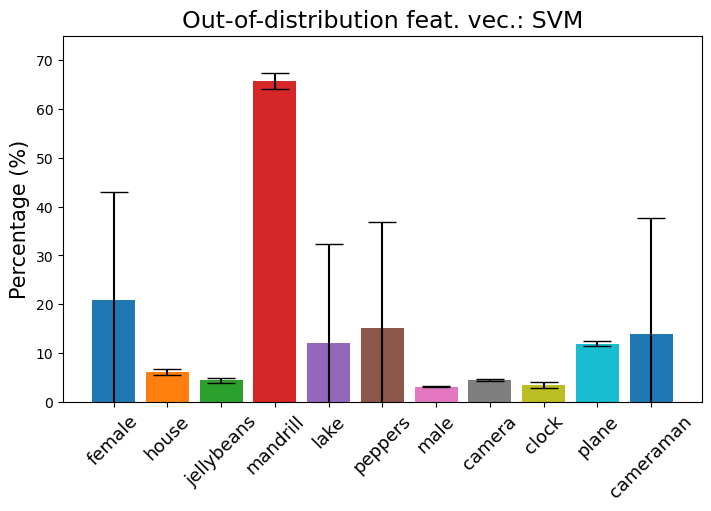

In [93]:
sgd_means = {}
sgd_stds = {}
for k, v in results_all["coarse"]["sgd"].items():
    l = LABELS[k] if k in LABELS else k
    sgd_means[l] = np.mean(v)
    sgd_stds[l] = np.std(v)

plt.figure(figsize=[7, 5], constrained_layout=True)
for i, m in enumerate(sgd_means):
    plt.bar(i, sgd_means[m], yerr=sgd_stds[m], capsize=10)
plt.ylim(0, 75)
plt.xticks(range(len(sgd_means)))
plt.gca().set_xticklabels(sgd_means.keys(), rotation=45, fontsize=13)
plt.title("Out-of-distribution feat. vec.: SVM", fontsize=17)
plt.ylabel("Percentage (%)", fontsize=15)
plt.savefig(f"{figures_path}/coarse_out_of_dist_svm.svg", dpi=600, bbox_inches="tight")

plt.savefig(f"{figures_path}/coarse_out_of_dist_svm.pdf", dpi=600, bbox_inches="tight")
plt.show()

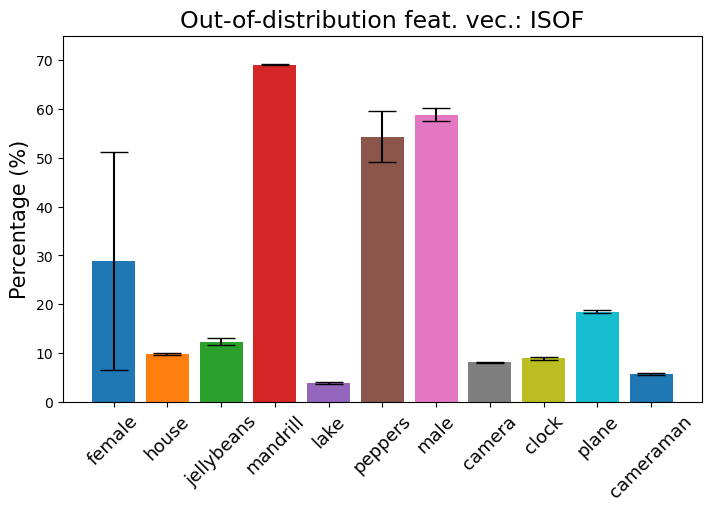

In [94]:
isof_means = {}
isof_stds = {}
for k, v in results_all["coarse"]["isof"].items():
    l = LABELS[k] if k in LABELS else k
    isof_means[l] = np.mean(v)
    isof_stds[l] = np.std(v)


plt.figure(figsize=[7, 5], constrained_layout=True)
for i, m in enumerate(isof_means):
    plt.bar(i, isof_means[m], yerr=isof_stds[m], capsize=10)
plt.ylim(0, 75)
plt.xticks(range(len(sgd_means)))

plt.gca().set_xticklabels(isof_means.keys(), rotation=45, fontsize=13)
plt.title("Out-of-distribution feat. vec.: ISOF", fontsize=17)
plt.ylabel("Percentage (%)", fontsize=15)
plt.savefig(f"{figures_path}/coarse_out_of_dist_isof.svg", dpi=600, bbox_inches="tight")

plt.savefig(f"{figures_path}/coarse_out_of_dist_isof.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [95]:
results_all = {}
results_all["coarse"] = {
    "sgd": deepcopy(sgd_outliers_percentages_f),
    "isof": deepcopy(isof_outliers_percentages_f),
}

### Same analysis for fine flakes

In [96]:
import skimage

In [97]:
fine_flakes = load_image_list_renormalize(
    [
        "/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/experiment_ground/ground_scaled_40_200.npy"
    ],
    img_format="npy",
)[0]
fine_flakes = skimage.filters.median(fine_flakes)

In [98]:
fine_flakes_feats, fine_flakes_patches, fine_flakes_rds, _ = get_feature_vectors(fine_flakes)

In [99]:
sgd_outliers_percentages_f = {}
for title in titles:
    for sgd in fitted_sgds[title]:
        inliers = sgd.predict(fine_flakes_feats)
        sgd_outliers_percentages_f.setdefault(title, [])
        sgd_outliers_percentages_f[title].append((inliers < 0).sum() / inliers.size * 100)
    print(
        f"{title: >10}",
        ", ".join(f"{o:3.2f}" for o in sgd_outliers_percentages_f[title]),
    )
results_all.setdefault("fine", {})
results_all["fine"]["sgd"] = sgd_outliers_percentages_f

    female 19.14, 16.56, 15.44, 18.14, 15.83
     house 9.69, 11.22, 9.97, 10.28, 10.56
    jbeans 6.03, 5.33, 5.61, 6.47, 5.56
  mandrill 10.94, 13.50, 10.58, 13.25, 11.33
      lake 3.53, 4.97, 5.33, 5.33, 5.22
   peppers 8.33, 8.61, 8.28, 7.89, 6.75
      male 6.89, 6.97, 7.14, 5.81, 6.97
camera_new 8.81, 7.56, 7.47, 8.39, 8.64
     clock 4.78, 6.14, 5.53, 5.75, 5.89
     plane 19.08, 21.03, 20.64, 19.86, 19.25
 cameraman 4.67, 4.83, 5.03, 6.08, 4.19


In [100]:
isof_outliers_percentages_f = {}
for title in titles:
    for sgd in fitted_isofs[title]:
        inliers = sgd.predict(fine_flakes_feats)
        isof_outliers_percentages_f.setdefault(title, [])
        isof_outliers_percentages_f[title].append((inliers < 0).sum() / inliers.size * 100)
    print(
        f"{title: >10}",
        ", ".join(f"{o:3.2f}" for o in isof_outliers_percentages_f[title]),
    )
results_all["fine"]["isof"] = isof_outliers_percentages_f

    female 17.97, 18.72, 18.00, 17.75, 18.14
     house 14.36, 12.97, 13.86, 13.64, 13.64
    jbeans 15.03, 18.22, 14.28, 14.11, 13.78
  mandrill 19.03, 18.89, 19.86, 19.28, 19.00
      lake 7.97, 8.08, 8.14, 8.53, 8.00
   peppers 10.31, 10.22, 10.39, 10.56, 10.56
      male 8.89, 8.94, 8.56, 9.00, 8.94
camera_new 11.78, 11.72, 12.00, 11.44, 11.47
     clock 11.83, 11.36, 12.00, 11.86, 11.89
     plane 29.61, 30.94, 29.06, 29.50, 30.56
 cameraman 9.56, 9.86, 9.58, 9.69, 9.83


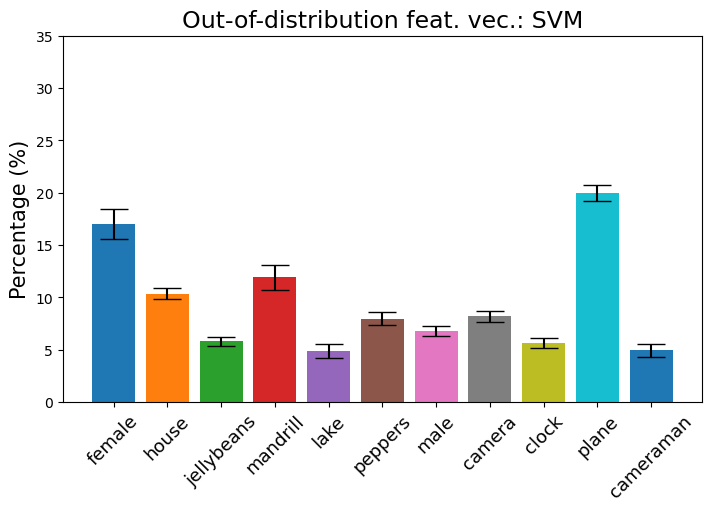

In [101]:
sgd_means = {}
sgd_stds = {}
for k, v in results_all["fine"]["sgd"].items():
    l = LABELS[k] if k in LABELS else k
    sgd_means[l] = np.mean(v)
    sgd_stds[l] = np.std(v)

plt.figure(figsize=[7, 5], constrained_layout=True)
for i, m in enumerate(sgd_means):
    plt.bar(i, sgd_means[m], yerr=sgd_stds[m], capsize=10)
plt.ylim(0, 35)
plt.xticks(range(len(sgd_means)))
plt.gca().set_xticklabels(sgd_means.keys(), rotation=45, fontsize=13)
plt.title("Out-of-distribution feat. vec.: SVM", fontsize=17)
plt.ylabel("Percentage (%)", fontsize=15)
plt.savefig(f"{figures_path}/fine_out_of_dist_svm.svg", dpi=600, bbox_inches="tight")

plt.savefig(f"{figures_path}/fine_out_of_dist_svm.pdf", dpi=600, bbox_inches="tight")
plt.show()

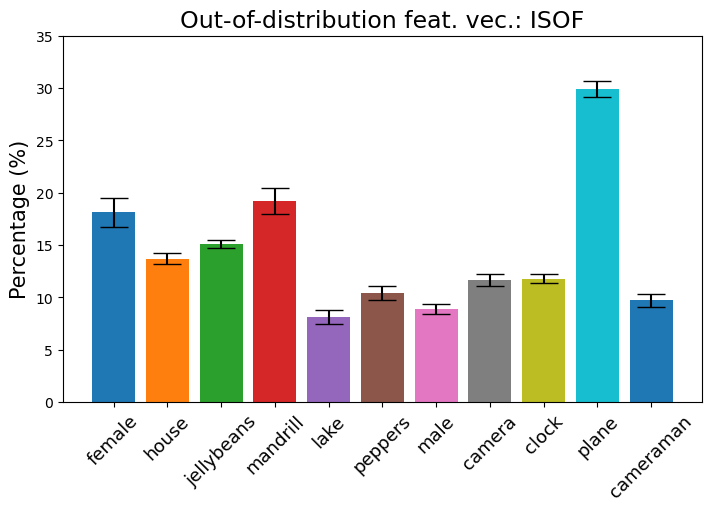

In [102]:
isof_means = {}
isof_stds = {}
for k, v in results_all["fine"]["isof"].items():
    l = LABELS[k] if k in LABELS else k
    isof_means[l] = np.mean(v)
    isof_stds[l] = np.std(v)

plt.figure(figsize=[7, 5], constrained_layout=True)
for i, m in enumerate(isof_means):
    plt.bar(i, isof_means[m], yerr=sgd_stds[m], capsize=10)
plt.ylim(0, 35)
plt.xticks(range(len(sgd_means)))
plt.gca().set_xticklabels(sgd_means.keys(), rotation=45, fontsize=13)
plt.title("Out-of-distribution feat. vec.: ISOF", fontsize=17)
plt.ylabel("Percentage (%)", fontsize=15)
plt.savefig(f"{figures_path}/fine_out_of_dist_svm.svg", dpi=600, bbox_inches="tight")

plt.savefig(f"{figures_path}/fine_out_of_dist_svm.pdf", dpi=600, bbox_inches="tight")
plt.show()

In [1]:
### For Shepp-Logan phantom

In [103]:
import odl

In [104]:
shape_this = [128, 128]
space_this = odl.uniform_discr([-1, -1], [1, 1], shape=shape_this)

sp_orig = renormalize(odl.phantom.shepp_logan(space_this, modified=True).asarray().T[::-1])

sp_nonzero = sp_orig[sp_orig > 0]
print(np.unique(sp_nonzero))

# sp_this = np.pad(sp_orig, [64 - shape_this // 2, 64 - shape_this // 2])
noise_this = odl.phantom.noise.white_noise(space_this, stddev=0.5).asarray()
sp_this = sp_orig + noise_this

[  10.   20.   30.   40.  100.]


In [105]:
sp_feats, sp_patches, sp_rds, _ = get_feature_vectors(sp_this)

In [106]:
try:
    results_all
except:
    results_all = {}
sgd_outliers_percentages_f = {}
for title in titles:
    for sgd in training_fits_all["fitted_sgds"][title]:
        inliers = sgd.predict(sp_feats)
        sgd_outliers_percentages_f.setdefault(title, [])
        sgd_outliers_percentages_f[title].append((inliers < 0).sum() / inliers.size * 100)
    print(
        f"{title: >10}",
        ", ".join(f"{o:3.2f}" for o in sgd_outliers_percentages_f[title]),
    )
results_all.setdefault("sp", {})
results_all["sp"]["sgd"] = sgd_outliers_percentages_f

    female 18.81, 19.50, 18.53, 17.55, 21.34
     house 12.04, 12.24, 10.94, 11.78, 13.77
    jbeans 10.90, 9.60, 9.62, 10.90, 11.21
  mandrill 21.56, 40.03, 35.21, 40.59, 34.86
      lake 8.99, 9.61, 11.31, 9.77, 9.39
   peppers 9.81, 10.46, 9.65, 9.81, 10.11
      male 9.48, 9.51, 9.60, 9.84, 10.04
camera_new 10.14, 9.14, 9.34, 9.87, 9.95
     clock 9.17, 9.07, 10.22, 11.27, 9.43
     plane 20.36, 21.55, 20.76, 18.00, 19.75
 cameraman 9.02, 9.22, 9.09, 13.32, 9.22


In [107]:
try:
    results_all
except:
    results_all = {}
isof_outliers_percentages_f = {}
for title in titles:
    for sgd in training_fits_all["fitted_isofs"][title]:
        inliers = sgd.predict(sp_feats)
        isof_outliers_percentages_f.setdefault(title, [])
        isof_outliers_percentages_f[title].append((inliers < 0).sum() / inliers.size * 100)
    print(
        f"{title: >10}",
        ", ".join(f"{o:3.2f}" for o in isof_outliers_percentages_f[title]),
    )
results_all.setdefault("sp", {})
results_all["sp"]["isof"] = isof_outliers_percentages_f

    female 20.90, 21.67, 21.26, 21.74, 21.26
     house 15.27, 14.03, 14.73, 14.67, 14.68
    jbeans 13.19, 13.13, 13.24, 12.71, 12.71
  mandrill 42.40, 41.46, 41.08, 41.44, 42.19
      lake 9.95, 10.04, 10.25, 10.04, 10.07
   peppers 11.36, 11.14, 11.18, 11.76, 11.07
      male 11.03, 11.51, 12.31, 11.20, 13.75
camera_new 11.63, 11.82, 12.23, 11.89, 12.08
     clock 12.15, 11.98, 12.17, 12.17, 12.11
     plane 26.60, 27.95, 25.54, 27.03, 27.48
 cameraman 10.49, 10.23, 10.19, 10.70, 10.19


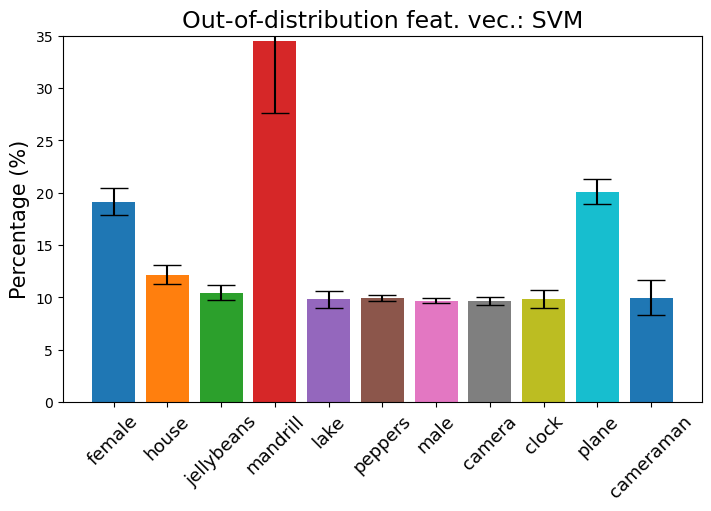

In [108]:
sgd_means = {}
sgd_stds = {}
for k, v in results_all["sp"]["sgd"].items():
    l = LABELS[k] if k in LABELS else k
    sgd_means[l] = np.mean(v)
    sgd_stds[l] = np.std(v)

plt.figure(figsize=[7, 5], constrained_layout=True)
for i, m in enumerate(sgd_means):
    plt.bar(i, sgd_means[m], yerr=sgd_stds[m], capsize=10)
plt.ylim(0, 35)
plt.xticks(range(len(sgd_means)))
plt.gca().set_xticklabels(sgd_means.keys(), rotation=45, fontsize=13)
plt.title("Out-of-distribution feat. vec.: SVM", fontsize=17)
plt.ylabel("Percentage (%)", fontsize=15)
plt.savefig(f"{figures_path}/sp_out_of_dist_svm.svg", dpi=600, bbox_inches="tight")

plt.savefig(f"{figures_path}/sp_out_of_dist_svm.pdf", dpi=600, bbox_inches="tight")
plt.show()

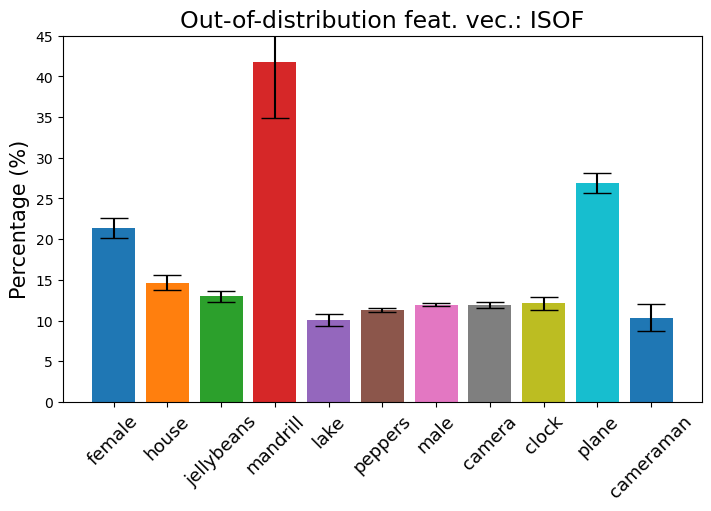

In [113]:
isof_means = {}
isof_stds = {}
for k, v in results_all["sp"]["isof"].items():
    l = LABELS[k] if k in LABELS else k
    isof_means[l] = np.mean(v)
    isof_stds[l] = np.std(v)

plt.figure(figsize=[7, 5], constrained_layout=True)
for i, m in enumerate(isof_means):
    plt.bar(i, isof_means[m], yerr=sgd_stds[m], capsize=10)
plt.ylim(0, 45)
plt.xticks(range(len(sgd_means)))
plt.gca().set_xticklabels(sgd_means.keys(), rotation=45, fontsize=13)
plt.title("Out-of-distribution feat. vec.: ISOF", fontsize=17)
plt.ylabel("Percentage (%)", fontsize=15)
plt.savefig(f"{figures_path}/sp_out_of_dist_svm.svg", dpi=600, bbox_inches="tight")

plt.savefig(f"{figures_path}/sp_out_of_dist_svm.pdf", dpi=600, bbox_inches="tight")
plt.show()